In [1]:
import pickle
import os

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt


from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_curve, recall_score

import swifter
from tqdm import tqdm 

import torch
from torch import nn
from torch.nn import functional as F

from torchmetrics import BinnedRecallAtFixedPrecision

from transformers import AutoTokenizer, AutoModel

#!pip install https://github.com/ufoym/imbalanced-dataset-sampler/archive/master.zip
from torchsampler import ImbalancedDatasetSampler



DATA_DIR = 'data'

In [2]:
datapath = os.path.join(DATA_DIR, 'menu_df_for_made.pkl')
with open(datapath, 'rb') as pickle_file:
    df = pickle.load(pickle_file)
df    

,product_id,category,name_dish,product_description,price,tags_menu
0,300146805,Пицца,"Милан, фирменная пицца","Болгарский перец, Грибы, Помидоры, Свиная выре...",620.0,{'пицца': 1}
1,300146840,Пицца,Фермерская пицца,"Пицца соус сливочный, Ветчина(индейка), Говяжи...",650.0,{'пицца': 1}
2,300146870,Пицца,"Пицца ""Четыре сезона""","Болгарский перец, Грибы, Лук, Маслины, Оливки,...",550.0,{'пицца': 1}
3,300146918,Пицца,Деревенская пицца,"Бекон, Ветчина(индейка), Грибы, Лук, Помидоры,...",620.0,{'пицца': 1}
4,300146996,Пицца,Пицца маргарита,"Пицца соус томатный, Сыр Моцарелла.",490.0,{'пицца': 1}
...,...,...,...,...,...,...
166,331415930,Драники,Картофельный драник со слабосоленым лососем и ...,,530.0,{'драники': 1}
167,331415931,Драники,Драник из свеклы,,195.0,{'драники': 1}
168,331415932,Драники,Драник из капусты,,195.0,{'драники': 1}
169,333962918,Драники,Драники картофельные,3 шт,139.0,{'драники': 1}


In [3]:
df['tags_menu'] = df['tags_menu'].apply(str)
df.dropna(inplace = True)
df.drop_duplicates(inplace = True)
df['id'] = np.arange(len(df))

df['tags_menu'].value_counts()

{'суши и роллы': 1}           554570
{'прочие напитки': 1}         319952
{'пицца': 1}                  297939
{'салат': 1}                  181316
{'сет': 1}                    142169
{'соус': 1}                   117449
{'гарниры': 1}                 71224
{'бургер': 1}                  52014
{'вок и лапша': 1}             45156
{'паста и ризотто': 1}         35556
{'закуски': 1}                 30962
{'шашлык': 1}                  28106
{'шаурма': 1}                  26208
{'пироги': 1}                  21769
{'сендвич': 1}                 20793
{'блины и оладьи': 1}          11163
{'рыба и морепродукты': 1}      9686
{'торты и пирожные': 1}         8221
{'поке и боулы': 1}             8028
{'пельмени и вареники': 1}      7989
{'хинкали и манты': 1}          7756
{'вегетарианская еда': 1}       7575
{'хлеб': 1}                     7519
{'кофе': 1}                     6047
{'птица': 1}                    5865
{'мясо': 1}                     5605
{'стейк': 1}                    4872
{

In [4]:
tags = df['tags_menu'].value_counts().index.values
tag_to_idx = {
    tag : i
    for i, tag in enumerate(tags)
}
idx_to_tag = {
    i : tag
    for i, tag in enumerate(tags)
}

In [5]:
df['target'] = df['tags_menu'].map(tag_to_idx)

In [6]:
df.product_id.unique().size, len(df)

(2049909, 2050015)

In [7]:
def sample_by_target(df, target_value, n, random_state=1):
    df_target = df[df.target == target_value]
    return df_target.sample(n=n, random_state=random_state) if len(df_target) > n else df_target

In [8]:
df_sample = pd.concat(
                [sample_by_target(df, name, 10000, random_state=i)
                 for i, name in enumerate(df.target.unique())],
                axis=0).reset_index(drop=True)

In [9]:
df_reserv = df[~df['id'].isin(df_sample['id'])]

In [10]:
len(df), len(df_sample), len(df_reserv), len(df) == len(df_sample) +len(df_reserv)

(2050015, 253669, 1796346, True)

In [11]:
df_sample['target'].value_counts()

0     10000
1     10000
15    10000
14    10000
13    10000
12    10000
11    10000
10    10000
9     10000
8     10000
7     10000
6     10000
5     10000
4     10000
3     10000
2     10000
16     9686
17     8221
18     8028
19     7989
20     7756
21     7575
22     7519
23     6047
24     5865
25     5605
26     4872
27     4496
28     3812
29     2568
30     1034
31     1017
32      567
33      369
34      237
35      171
36      111
37       96
38       28
Name: target, dtype: int64

In [12]:
class Rubert:
    def __init__(self):
        self.tokenizer = AutoTokenizer.from_pretrained("cointegrated/rubert-tiny")
        self.model = AutoModel.from_pretrained("cointegrated/rubert-tiny")
        self.model.eval()
        
    def text_emb(self, text):
        t = self.tokenizer(text, padding=True, truncation=True, return_tensors='pt')
        with torch.no_grad():
            model_output = self.model(**{k: v.to(self.model.device) for k, v in t.items()})
        embeddings = model_output.last_hidden_state[:, 0, :]
        embeddings = torch.nn.functional.normalize(embeddings)
        return embeddings[0].cpu().numpy() 

In [13]:
def text_emb(df):
    texts = df['name_dish'] + ' ' + df['product_description']
    texts = texts.str.lower().values
    
    rubert_model = Rubert()
    emb = [rubert_model.text_emb(text) for text in tqdm(texts)]
    
    return np.array(emb)

def cash_text_emb(df, filepath):
    if not os.path.exists(filepath):
        if not os.path.exists(os.path.dirname(filepath)):
            os.mkdir(os.path.dirname(filepath))

        emb = text_emb(df)
        target = df['target'].values
        with open(filepath, 'wb') as handle:
            pickle.dump([emb, target], handle)
    else:
        with open(filepath, 'rb') as handle:
            emb, target = pickle.load(handle)  
    return emb, target

In [14]:
%%time
emb_path = os.path.join(DATA_DIR, 'sample', 'text_emb_10000.pkl')
emb_sample, target_sample = cash_text_emb(df_sample, emb_path)

CPU times: user 765 µs, sys: 112 ms, total: 113 ms
Wall time: 113 ms


In [15]:
X = emb_sample
y = target_sample
X_train, X_test, y_train, y_test =   train_test_split(X, y, 
                                                      stratify=y, 
                                                      test_size=0.1)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train,
                                                      stratify=y_train,
                                                      test_size=0.3)

In [16]:
train_dataset = torch.utils.data.TensorDataset(torch.FloatTensor(X_train), torch.LongTensor(y_train))

In [17]:
train_loader = torch.utils.data.DataLoader(
    train_dataset,
    sampler=ImbalancedDatasetSampler(train_dataset, 
                                     callback_get_label=lambda d: d.tensors[1]
                                    ),
    batch_size=64
)

In [18]:
def init_weights(layer):
    if type(layer) == nn.Linear:
        nn.init.xavier_normal_(layer.weight)
        #nn.init.uniform_(layer.weight)

In [19]:
model = nn.Sequential(
    nn.Linear(312, 39),
    )
#model.apply(init_weights)
model.train()

criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)


In [20]:
def train_model(net, criterion, optimizer, trainloader, num_epochs=5):
    for epoch in range(num_epochs):
        running_loss = 0.0
        for i, data in enumerate(trainloader, 0):
            inputs, labels = data
            
            optimizer.zero_grad()
            
            preds = net(inputs)
            loss = criterion(preds, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            if i % 200 == 199:
                print('Epoch {0}/{1}, iteration {2}, loss: {3:.3f}'.format(epoch + 1, num_epochs, i + 1, 
                                                                          running_loss / 200))
                running_loss = 0.0
        print()

    print('Finished Training')
    
    return net

In [21]:
train_model(model, criterion, optimizer, train_loader, num_epochs=10)

Epoch 1/10, iteration 200, loss: 3.563
Epoch 1/10, iteration 400, loss: 3.398
Epoch 1/10, iteration 600, loss: 3.276
Epoch 1/10, iteration 800, loss: 3.174
Epoch 1/10, iteration 1000, loss: 3.076
Epoch 1/10, iteration 1200, loss: 3.001
Epoch 1/10, iteration 1400, loss: 2.936
Epoch 1/10, iteration 1600, loss: 2.879
Epoch 1/10, iteration 1800, loss: 2.805
Epoch 1/10, iteration 2000, loss: 2.757
Epoch 1/10, iteration 2200, loss: 2.704
Epoch 1/10, iteration 2400, loss: 2.647

Epoch 2/10, iteration 200, loss: 2.576
Epoch 2/10, iteration 400, loss: 2.540
Epoch 2/10, iteration 600, loss: 2.494
Epoch 2/10, iteration 800, loss: 2.456
Epoch 2/10, iteration 1000, loss: 2.430
Epoch 2/10, iteration 1200, loss: 2.395
Epoch 2/10, iteration 1400, loss: 2.343
Epoch 2/10, iteration 1600, loss: 2.335
Epoch 2/10, iteration 1800, loss: 2.282
Epoch 2/10, iteration 2000, loss: 2.274
Epoch 2/10, iteration 2200, loss: 2.240
Epoch 2/10, iteration 2400, loss: 2.235

Epoch 3/10, iteration 200, loss: 2.200
Epoch 3

Sequential(
  (0): Linear(in_features=312, out_features=39, bias=True)
)

In [22]:
model.eval()
logit_train = model(torch.FloatTensor(X_train))
prob_train = F.softmax(logit_train, dim=-1).detach().numpy()

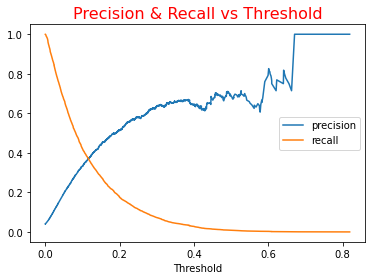

In [23]:
label = 10
pre, rec, thr = precision_recall_curve(y_train == label, prob_train[:, label])

plt.plot(thr, pre[:-1], label='precision')
plt.plot(thr, rec[1:], label='recall')
plt.xlabel('Threshold')
plt.title('Precision & Recall vs Threshold', c='r', size=16)
plt.legend()
plt.show() 

In [24]:
def recall_at_prec(true_label, probs, min_precision=0.7):
    recalls, thresholds = [], []
    for label in range(probs.shape[-1]):
        try:
            pre, rec, thr = precision_recall_curve(true_label == label, probs[:, label])
            idx = np.where(pre > 0.7)[0][0]
            if idx >= len(pre):
                idx = len(pre) - 1
            recalls.append(rec[idx])
            thresholds.append(thr[idx - 1])
        except Exception as e:
            print(label, e)
    return np.array(recalls), np.array(thresholds)

In [25]:
recalls_train, thresholds_train = recall_at_prec(y_train, prob_train, min_precision=0.7)
recalls_train, thresholds_train

(array([0.69174603, 0.70396825, 0.7868254 , 0.59920635, 0.72571429,
        0.79460317, 0.51857143, 0.7668254 , 0.62190476, 0.65809524,
        0.01396825, 0.61650794, 0.82571429, 0.70634921, 0.81650794,
        0.75047619, 0.3216978 , 0.66383472, 0.81313031, 0.8301212 ,
        0.95783872, 0.13660172, 0.51023855, 0.65345235, 0.70121786,
        0.        , 0.51873574, 0.78566384, 0.74812656, 0.21384425,
        0.59662577, 0.19812793, 0.05602241, 0.29310345, 0.00671141,
        0.46296296, 0.        , 0.14754098, 0.94444444]),
 array([0.2132085 , 0.21372826, 0.15489896, 0.22568774, 0.1734962 ,
        0.17572308, 0.2408425 , 0.19575891, 0.17191991, 0.15822569,
        0.45762247, 0.1867052 , 0.14074962, 0.14415628, 0.10700487,
        0.13270418, 0.26615477, 0.17474626, 0.17427434, 0.13457808,
        0.07289887, 0.1815476 , 0.2314267 , 0.27347612, 0.19472453,
        0.6315226 , 0.27510968, 0.20302838, 0.22549285, 0.31107652,
        0.49129722, 0.7275238 , 0.7310188 , 0.6711577 , 0.

In [26]:
BinnedRecallAtFixedPrecision(min_precision=0.7, 
                            num_classes=len(tags),
                            thresholds=100,
                            )(torch.FloatTensor(prob_train), torch.LongTensor(y_train))

(tensor([0.6844, 0.6986, 0.7798, 0.5919, 0.7157, 0.7894, 0.5160, 0.7610, 0.6060,
         0.6519, 0.0063, 0.6106, 0.8252, 0.6905, 0.8129, 0.7370, 0.3183, 0.6563,
         0.8092, 0.8198, 0.9542, 0.1366, 0.5098, 0.6479, 0.6991, 0.0000, 0.5057,
         0.7807, 0.7448, 0.2114, 0.5936, 0.1903, 0.0504, 0.2845, 0.0067, 0.4630,
         0.0000, 0.1475, 0.9444]),
 tensor([2.2222e-01, 2.2222e-01, 1.6162e-01, 2.3232e-01, 1.8182e-01, 1.8182e-01,
         2.4242e-01, 2.0202e-01, 1.8182e-01, 1.6162e-01, 5.2525e-01, 1.9192e-01,
         1.4141e-01, 1.5152e-01, 1.1111e-01, 1.4141e-01, 2.7273e-01, 1.8182e-01,
         1.8182e-01, 1.4141e-01, 8.0808e-02, 1.8182e-01, 2.3232e-01, 2.8283e-01,
         2.0202e-01, 1.0000e+06, 2.8283e-01, 2.1212e-01, 2.3232e-01, 3.1313e-01,
         4.9495e-01, 7.3737e-01, 7.5758e-01, 6.7677e-01, 9.7980e-01, 8.1818e-01,
         1.0000e+06, 9.3939e-01, 7.8788e-01]))

In [27]:
recalls_train.mean()

0.5424878746695153

In [28]:
np.where(recalls_train < 0.2)

(array([10, 21, 25, 31, 32, 34, 36, 37]),)

In [29]:
tags[np.where(recalls_train < 0.2)]

array(["{'закуски': 1}", "{'вегетарианская еда': 1}", "{'мясо': 1}",
       "{'пирожки': 1}", "{'плов': 1}", "{'сырники и запеканки': 1}",
       "{'азиатский суп': 1}", "{'омлет и яичница': 1}"], dtype=object)

In [30]:
def recall_at_thresholds(true_label, probs, thresholds):
    recalls = []
    preds = probs > thresholds
    for label in range(probs.shape[-1]):
        try:
            rec = recall_score(true_label == label, preds[:, label])
            recalls.append(rec)
        except Exception as e:
            print(label, e)
    return np.array(recalls)

In [31]:
recall_at_thresholds(y_train, prob_train, thresholds_train).mean()


0.5424878746695153

In [32]:
logit_valid = model(torch.FloatTensor(X_valid))
prob_valid = F.softmax(logit_valid, dim=-1).detach().numpy()
recall_at_thresholds(y_valid, prob_valid, thresholds_train).mean()

0.5319723359927631

In [33]:
recall_at_thresholds(y_valid, prob_valid, thresholds_train)

array([0.68814815, 0.70259259, 0.77925926, 0.58518519, 0.73037037,
       0.77925926, 0.51444444, 0.76814815, 0.63222222, 0.67592593,
       0.01185185, 0.61851852, 0.82111111, 0.71111111, 0.81703704,
       0.75259259, 0.30363289, 0.67927928, 0.80119926, 0.82939268,
       0.96943649, 0.12616137, 0.5270936 , 0.65401102, 0.68308081,
       0.        , 0.51291793, 0.78500824, 0.75413022, 0.2020202 ,
       0.51971326, 0.17883212, 0.03267974, 0.22      , 0.        ,
       0.36956522, 0.        , 0.15384615, 0.85714286])